[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph_sdk langchain_groq


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [2]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

model = ChatGroq(
    model="gemma2-9b-it",
    temperature=0.0,
    max_retries=2,
    # other params...
)

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

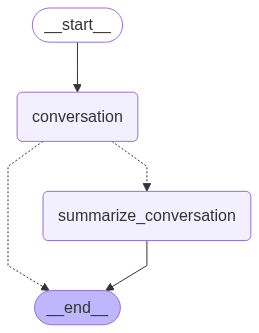

In [13]:
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from typing import Literal


# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) ->  Literal["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. Synchronous methods execute tasks one after another, with each task waiting for the previous one to complete, creating a blocking, sequential flow of execution that is simple to understand but can be inefficient. Asynchronous methods allow tasks to run independently, often in the background, without halting the main process, resulting in non-blocking, concurrent execution that enhances performance and responsiveness, though it can be more complex to manage
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [15]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hi Lance! 👋 \n\nIt's nice to meet you. What can I do for you today? 😊  \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 54, 'total_tokens': 81, 'completion_time': 0.049090909, 'prompt_time': 0.001718099, 'queue_time': 0.25368152, 'total_time': 0.050809008}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--82f8c598-1f2c-438a-9530-272d8ba755f3-0', usage_metadata={'input_tokens': 54, 'output_tokens': 27, 'total_tokens': 81})}}


Let's now just print the state update.

In [16]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! 👋 

It's nice to meet you. What can I do for you today? 😊  


It seems like you're trying to introduce yourself.  I'm happy to meet you, Lance!  

Is there anything you'd like to talk about or ask me?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [ ]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"): # stream_mode changed to values
    for m in event['messages']: # event['messages'] is the list of all messges here 
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! 👋

It's nice to meet you. What can I do for you today? 😊
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the KFC")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"): # loop for every token generated
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conver

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [ ]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"]) # print for each token generated

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content='4', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content='9', additional_kwargs={}, response_metadata={}, id='run--86bab16a-4333-4358-b289-163192500678')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [9]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |4|9|ers| are| a| professional| American| football| team| based| in| Santa| Clara|,| California|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| club| of| the| league|'|s| National| Football| Conference| (|NFC|)| West| division|.| |

|Here|'|s| some| key| information| about| the| |4|9|ers|:|

|**|History|:**|

|*| **|Founded|:**| |1|9|4|6|
|*| **|Original| Location|:**| San| Francisco|,| California|
|*| **|Home| Stadium|:**| Levi|'|s| Stadium| (|since| |2|0|1|4|)|
|*| **|Previous| Stadium|s|:**| Candles|tick| Park| (|1|9|7|1|-|2|0|1|3|)|
|*| **|Champions|hips|:**| |5| Super| Bowl| victories| (|XVI|,| XIX|,| XXIII|,| XXIV|,| XXIX|)|

|**|Notable| Players|:**|

|*| **|Joe| Montana|:**| Legendary| quarterback|,| led| the| team| to| four| Super| Bowl| victories|.|
|*| **|Jerry| Rice|:**| Widely| considered| the| greatest| wide| receiver| of| all| time|,| holds| numerous| NFL| receiving| records|.|
|*| **|Steve| Young|:**| Another| Hall| o